<a href="https://colab.research.google.com/github/AryanSai/Deep-Learning/blob/main/Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.models import vgg19
from PIL import Image
import torchvision.models as models
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

# Loading the Image

VGG networks are trained on images with each channel normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]. We will use them to normalize the image before sending it into the network.

 Normalizing input data can help in faster convergence during training. By centering the data around zero mean and scaling it to have unit variance, we ensure that the optimization algorithm used during training (such as gradient descent) behaves more consistently and efficiently.


In [ ]:
def load_image(img_path):
    image = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([  #compose several transforms together
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],  # mean values
                             std=[0.229, 0.224, 0.225])   # standard deviation
    ])
    image = transform(image).unsqueeze(0)  # add batch dimension at index 0
    return image

content = load_image('/content/content.png').to(device)
style = load_image('/content/style.png').to(device)

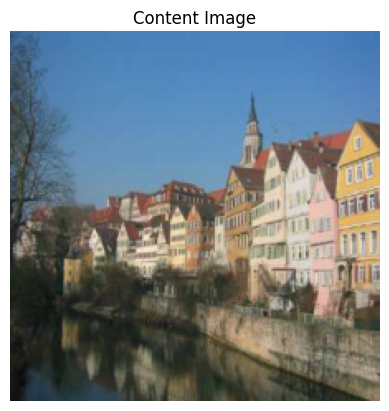

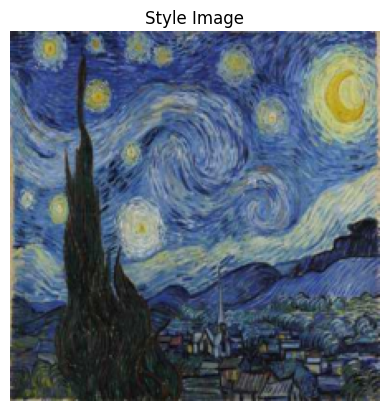

In [ ]:
def denormalize(tensor):
  # reshapes the tensor into a 3D tensor with dimensions (3, 1, 1)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(device)
    denormalized_tensor = tensor.to(device) * std + mean
    return denormalized_tensor

def display_image(tensor, title):
    image = tensor.cpu().clone()  # clone the tensor for printing purpose
    image = image.squeeze(0)      # remove the batch dimension
    image = denormalize(image)    # denormalize the image
    image = image.clip(0, 1)
    image = transforms.ToPILImage()(image)  # convert tensor to PIL image

    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

display_image(content, title='Content Image')
display_image(style, title='Style Image')

# VGG
two Sequential modules: features (containing convolution and pooling layers), and classifier (containing fully connected layers)

 We do not use any of the fully connected layers. hence only features



In [ ]:
vgg = models.vgg19(pretrained=True).features

# let us freeze the parameters to prevent from updation during optimisation
for param in vgg.parameters():
    param.requires_grad_(False)

print(vgg)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 83.5MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

# Feature Extraction
We need to send the image through the vgg model and extract features of the given set of layers(from paper).

In [ ]:
def extract_features(image, vgg, layers):
    # store the extracted features in a dictionary with their layer index
    features = {}

    for name, layer in vgg._modules.items():
        image = layer(image)
        if name in layers:
            features[layers[name]] = image

    return features

# Gram Matrix
Output of conv has four dimensions: batch size, depth, height and width. Get them from the tensor.size()



*   see for correlations between multiple layers(how similar they are)
*   flatten the spatial dimensions(x,y) => 3d conv layer into a matrix of values and multiply with its transpose
*   normalize Gram by dividing by the total number of elements in each feature map.



In [ ]:
def gram_matrix(input):
    # get the batch_size, depth, height, and width of the Tensor
    # here batch_size is 1, so we can ignore it
    _, depth, height, width = input.size()
    features = input.view(depth, height * width)  # resize to make it 2d -- flatten the spatial dimension

    # mm for matrix multiplication
    gram = torch.mm(features, features.t()) #.t for transpose

    return gram.div(depth * height * width)
    # return gram

# Loss
*   we are not minimising the classification error, i.e. we dont even train the cnn....
*   we only change the target image and update until its content rep is same as the original....
*   used only for feature extraction and reducing the above loss
*   alpha and beta are weights to balance both content and style(examples in paper) => smaller the ratio the better it is
*   List item

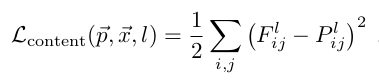


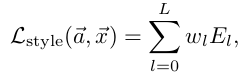


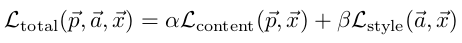




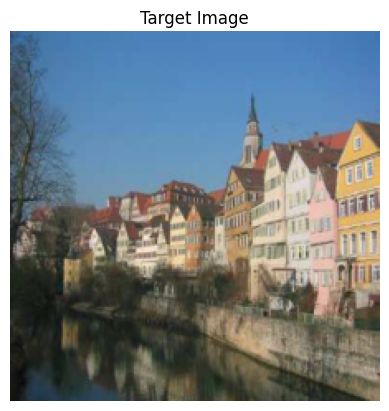

In [ ]:
# α and β are the weighting factors for content and style reconstruction
# the ratio α/β was either 1 × 10−3 (some more options were also given in the paper)
alpha = 1
beta = 1000000

# dictionary mapping layer indices to their names
style_layers = {'0' : 'conv1_1',
                '5' : 'conv2_1',
                '10': 'conv3_1',
                '19': 'conv4_1',
                '28': 'conv5_1'}

content_layer ={'21': 'conv4_2'}

# extract the content and style features
content_feature = extract_features(content, vgg, content_layer)
style_features = extract_features(style, vgg, style_layers)

# calculate the gram matrices for each layer of our style image
gram_matrices = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# target is a copy of the content image, this is better than a white noise image
# requires grad because we update only this
target = content.clone().requires_grad_(True).to(device)

display_image(target, title='Target Image')

## LBFGS

Total loss:  2.9336485862731934


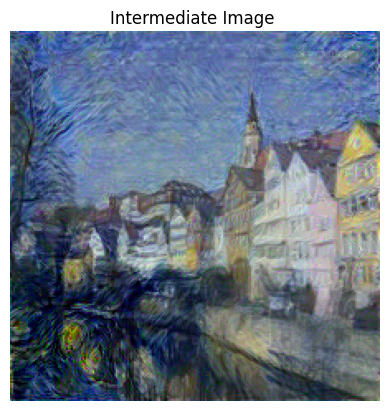

Total loss:  2.908327102661133


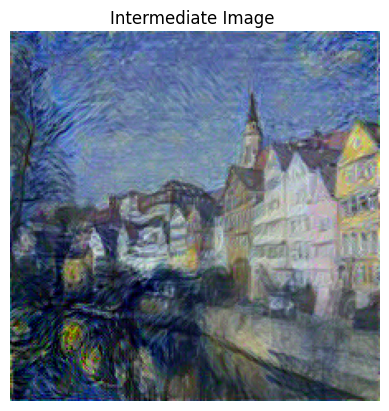

Total loss:  2.897846221923828


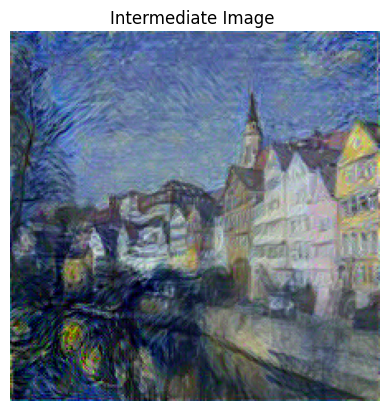

Total loss:  2.891934394836426


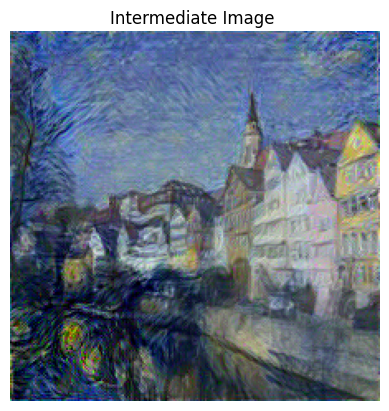

Total loss:  2.888213872909546


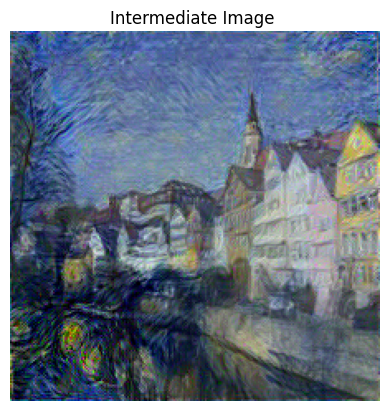

Total loss:  2.8855578899383545


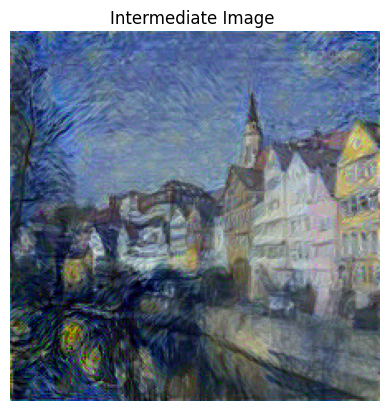

In [ ]:
optimizer = optim.LBFGS([target])

def closure():
    optimizer.zero_grad()
    # extract the content and style features from the target image
    target_content_feature = extract_features(target, vgg, content_layer)
    target_style_features = extract_features(target, vgg, style_layers)

    content_loss = F.mse_loss(content_feature['conv4_2'], target_content_feature['conv4_2'])

    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_layers.values():

        # get the "target" style representation for the layer
        target_feature = target_style_features[layer]

        # calculate the gram matrix for the target image layer
        target_gram = gram_matrix(target_feature)

        # get the gram matrix of the the original
        style_gram = gram_matrices[layer]

        # weight(wl) for each of the style layers is 1/5 (0.2)
        layer_style_loss = 0.2 * F.mse_loss(style_gram, target_gram)

        # add to the style loss
        style_loss += layer_style_loss

    # calculate the *total* loss
    total_loss = alpha * content_loss + beta * style_loss

    total_loss.backward()
    return total_loss

for i in range(1, 301):
    optimizer.step(closure)

    # display intermediate images and print the loss
    if i % 50 == 0:
        print('Total loss: ', closure().item())
        display_image(target, title='Intermediate Image ')

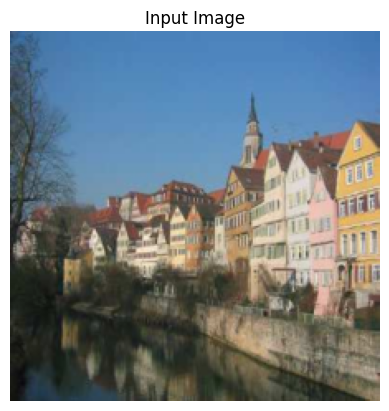

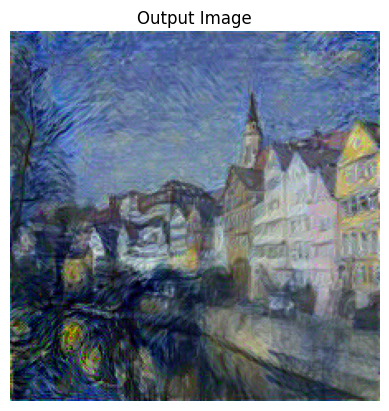

In [ ]:
display_image(content, title='Input Image')
display_image(target, title='Output Image')

## Adam Optimizer

Total loss:  2.88175630569458


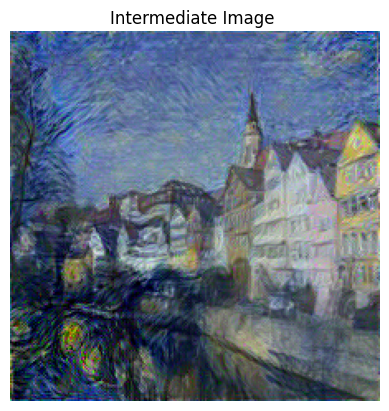

Total loss:  2.8788366317749023


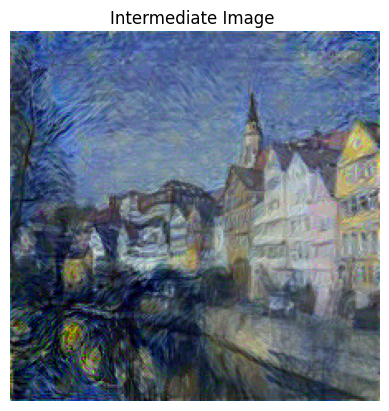

Total loss:  2.8764538764953613


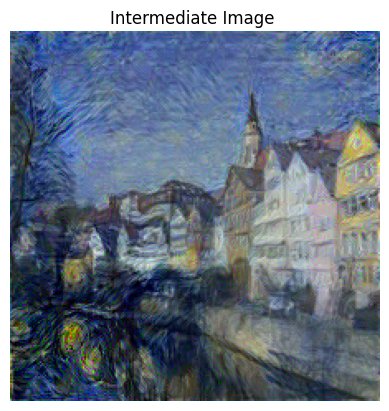

Total loss:  2.874579906463623


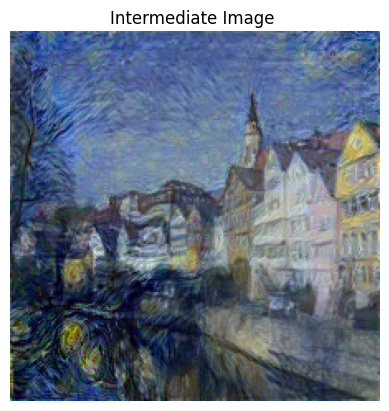

Total loss:  2.872875928878784


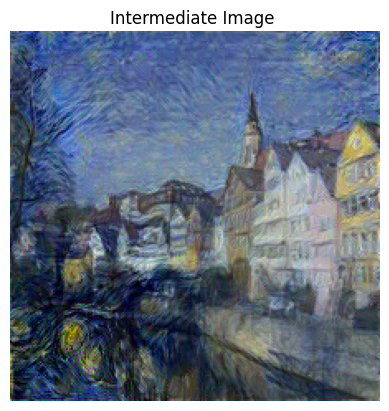

Total loss:  2.8713154792785645


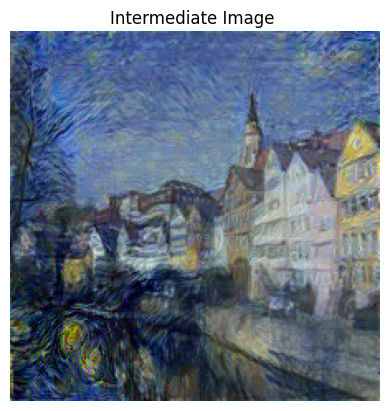

Total loss:  2.870062828063965


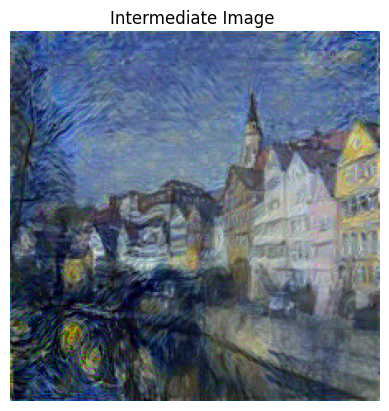

Total loss:  2.868990659713745


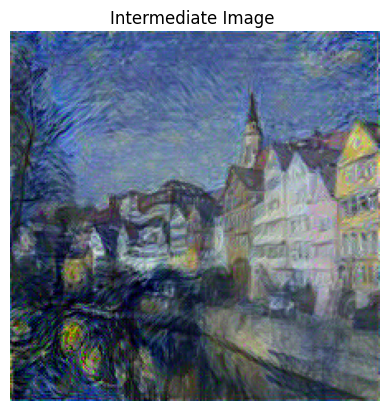

Total loss:  2.8679611682891846


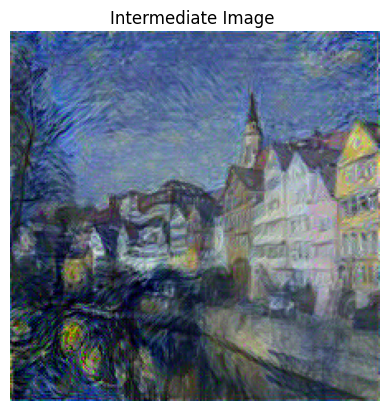

Total loss:  2.8668723106384277


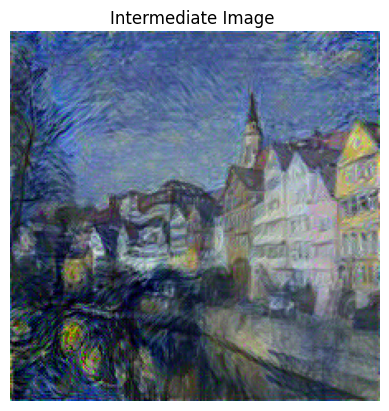

In [ ]:

optimizer = optim.Adam([target], lr=0.003)
# optimizer = optim.LBFGS([target])
for i in range(1, 5001):
    # extract the content and style features from the target image
    target_content_feature = extract_features(target, vgg, content_layer)
    target_style_features = extract_features(target, vgg, style_layers)

    content_loss = F.mse_loss(content_feature['conv4_2'], target_content_feature['conv4_2'])

    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_layers.values():

        # get the "target" style representation for the layer
        target_feature = target_style_features[layer]

        # calculate the gram matrix for the target image layer
        target_gram = gram_matrix(target_feature)

        # get the gram matrix of the the original
        style_gram = gram_matrices[layer]

        # weight(wl) for each of the style layers is 1/5 (0.2)
        layer_style_loss =  0.2 * F.mse_loss(style_gram, target_gram)

        # add to the style loss
        # style_loss += layer_style_loss
        style_loss += layer_style_loss

    # calculate the *total* loss
    total_loss = alpha * content_loss + beta * style_loss

    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # display intermediate images and print the loss
    if  i % 500 == 0:
      print('Total loss: ', total_loss.item())
      # print(target)
      display_image(target, title='Intermediate Image ')

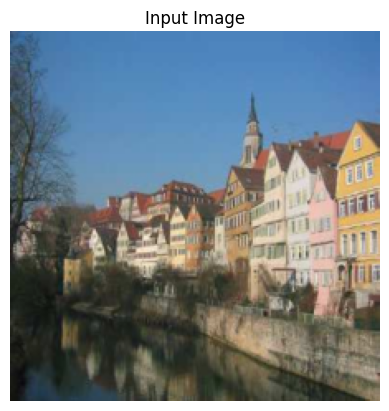

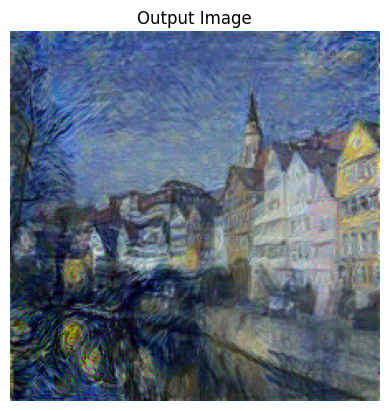

In [ ]:
display_image(content, title='Input Image')
display_image(target, title='Output Image')